In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# параметры отображения картинок
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 200

52 platelets found


Text(0.5, 1.0, 'final')

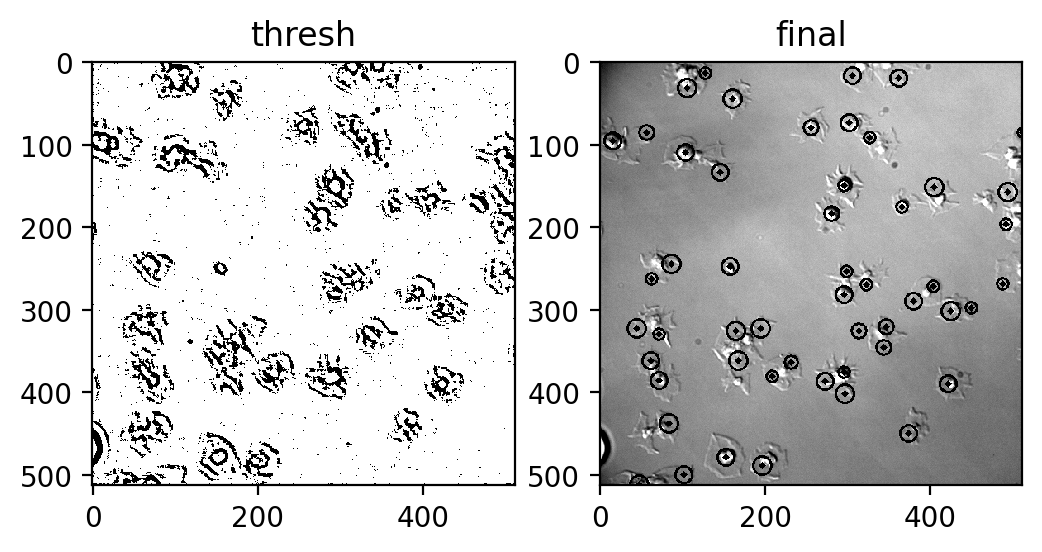

In [4]:
"""
ПЕРВЫЙ СПОСОБ
"""
# исходное изображение
image = cv2.imread(r'C:\Users\XPS\Desktop\platelets\PLTS_main.png',0)
img = image.copy()
# Гауссово размытие
img = cv2.medianBlur(img,7)
# Пороговая обработка
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
# Преобразование Хафа
circles = cv2.HoughCircles(th3,cv2.HOUGH_GRADIENT,1.2,minDist = 25,param1=15,param2=12,minRadius=6,maxRadius=12)
circles = np.uint16(np.around(circles))
copy_cimg = image.copy()

for i in circles[0,:]:
    # окружность
    cv2.circle(copy_cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # центр круга
    cv2.circle(copy_cimg,(i[0],i[1]),2,(0,0,255),3)

# plt.imsave('plt_out.png',copy_cimg)
print(circles.shape[1], 'platelets found')
plt.subplot(121),plt.imshow(th3,cmap = 'gray')
plt.title('thresh')
plt.subplot(122),plt.imshow(copy_cimg,cmap = 'gray')
plt.title('final')

In [ ]:
"""
ВТОРОЙ СПОСОБ
"""

In [7]:
def get_template():
    """
    Функция создает шаблон формы тромбоцита
    """
    temp = np.zeros((60,60))
    n = 1
    n_max = 6
    #совмещение нескольких изображений
    for n in range(1,n_max):
        name = r'C:\Users\XPS\Desktop\platelets\plt{}.png'.format(n)
        plate = cv2.imread(name,0)
        temp += plate
    #нормировка
    temp /= (n_max-1)
    plt.imsave('template.png',temp)
    return temp

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x, y), (x_plus_w, y_plus_h), color, 2)

    cv2.putText(img, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

def compute_iou(a, b, epsilon=1e-5):
    """ 
    Выполняется подсчет коэффициента сходства Жаккара (Intesection over union) между двумя ячейками.
    Аргументы: a,b - словари, содержащие 
            {top_left_x} (float)
            {top_left_y} (float)
            {bottom_right_x} (float)
            {bottom_right_y} (float)
        
    """
    # приведение к более удобной форме
    a = [a["TOP_LEFT_X"],a["TOP_LEFT_Y"],a["BOTTOM_RIGHT_X"], a["BOTTOM_RIGHT_Y"]]
    b = [b["TOP_LEFT_X"],b["TOP_LEFT_Y"],b["BOTTOM_RIGHT_X"], b["BOTTOM_RIGHT_Y"]]

    # координаты
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # пересечение
    width = (x2 - x1)
    height = (y2 - y1)
    # отсутствие пересечения
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # суммарная площадь
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # относительное перекрытие
    iou = area_overlap / (area_combined+epsilon)
    return iou


def non_max_suppression(objects,non_max_suppression_threshold=0.8,score_key="MATCH_VALUE"):
    """
    Функция фильтрует пересекающиеся ячейки, оставляя только те, у которых максимальное совпадение с шаблоном
    
    Аргументы:
        objects (List[dict]): список словарей, содержащих:
            {score_key} (float)
            {top_left_x} (float)
            {top_left_y} (float)
            {bottom_right_x} (float)
            {bottom_right_y} (float)
        non_max_suppression_threshold (float): Минимальный коэффициент Жаккара для осуществления фильтрации
       .
    """
    sorted_objects = sorted(objects, key=lambda obj: obj[score_key], reverse=True)
    filtered_objects = []
    for object_ in sorted_objects:
        overlap_found = False
        for filtered_object in filtered_objects:
            iou = compute_iou(object_, filtered_object)
            if iou > non_max_suppression_threshold:
                overlap_found = True
                break
        if not overlap_found:
            filtered_objects.append(object_)
    return filtered_objects

48 platelets found


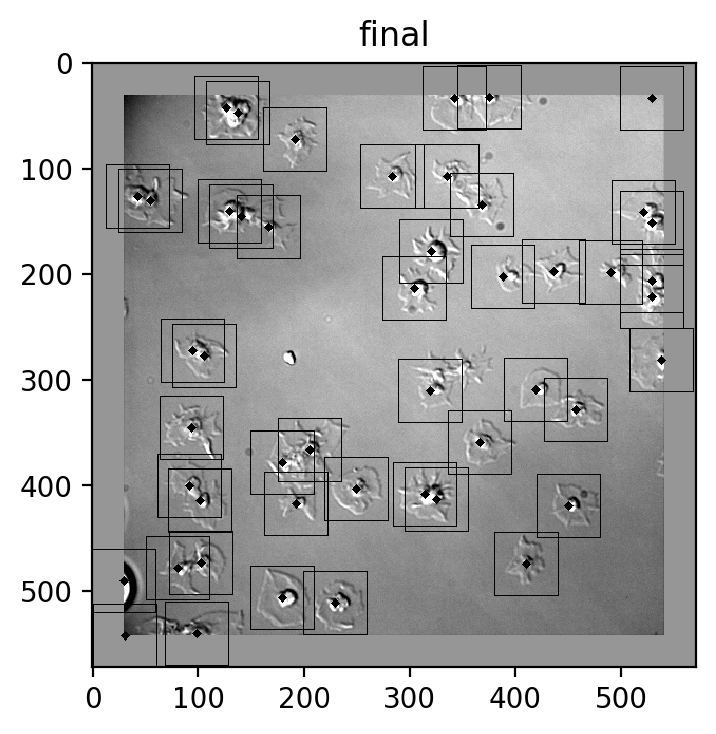

In [11]:
# пустой список для ячеек
detections = []
# исходная картинка
img =  cv2.imread(r'C:\Users\XPS\Desktop\platelets\PLTS_main.png',0)
# создание шаблона
get_template()
template = cv2.imread('template.png',0)

# размеры шаблона
w = int(template.shape[0]/2)
h = int(template.shape[1]/2)
thresh = 0.25

# добавление рамки
top, bottom = h,h
left, right = w,w
color = [150,150,150] #gray
image = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
cv2.imwrite(f"plt_padded.png", image)

# соответствие шаблону
template_matching = cv2.matchTemplate(template, image, cv2.TM_CCOEFF_NORMED)
match_locations = np.where(template_matching >= thresh)

# создание словаря для каждой ячейки
for (x, y) in zip(match_locations[1], match_locations[0]):
    match = {
        "TOP_LEFT_X": x,
        "TOP_LEFT_Y": y,
        "BOTTOM_RIGHT_X": x + 2*w,
        "BOTTOM_RIGHT_Y": y + 2*h,
        "MATCH_VALUE": template_matching[y, x],
    }
    detections.append(match)
    
# сохранение промежуточной картинки    
image_full_detections = image.copy()
for detection in detections:
    cv2.rectangle(
        image_full_detections,
        (detection["TOP_LEFT_X"], detection["TOP_LEFT_Y"]),
        (detection["BOTTOM_RIGHT_X"], detection["BOTTOM_RIGHT_Y"]),2)

cv2.imwrite(f"plt_result.png", image_full_detections)
# plt.imshow(image_full_detections)

# отбор ячеек
NMS_THRESHOLD = 0.6
detections_nms = non_max_suppression(detections, non_max_suppression_threshold=NMS_THRESHOLD)

# сохранение финальной картинки
image_with_detections = image.copy()
for detection in detections_nms:
    cv2.rectangle(image_with_detections,(detection["TOP_LEFT_X"], detection["TOP_LEFT_Y"]),\
        (detection["BOTTOM_RIGHT_X"], detection["BOTTOM_RIGHT_Y"]),2)
    #точка в центре ячейки
    cv2.circle(image_with_detections,(detection["TOP_LEFT_X"]+w, detection["TOP_LEFT_Y"]+h),2,(0,0,255),3)
    
cv2.imwrite(f"plt_final.png", image_with_detections)
plt.imshow(image_with_detections)
plt.title('final')

print(len(detections_nms), 'platelets found')